In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta
import json
import itertools
from tqdm import tqdm
import os
os.chdir("/content/drive/MyDrive/projects/Scrabble_Player_Rating/")
from model.model import RandomForest_rint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split

In [57]:
# 設定ファイルの読み込み
conf = json.load(open("config/config.json"))
conf_model = json.load(open("config/config_RandomForest.json"))
conf.update(conf_model)

all_params = [dict(zip(conf["cv_params"].keys(), v)) for v in itertools.product(*conf["cv_params"].values())]
print(len(all_params))

random_state = conf["random_state"]
n_splits = conf["n_splits"]
test_size = conf["test_size"]

24


In [58]:
df_train = pd.read_csv("data/train_f.csv")
df_sub = pd.read_csv("data/test_f.csv")
display(df_train.head())

# nicknameからtrainとtestを決める
train_nickname, test_nickname = train_test_split(df_train["nickname"].unique().tolist(), test_size=test_size, random_state=random_state)
df_test = df_train.query("nickname==@test_nickname")
df_train = df_train.query("nickname==@train_nickname")
print(len(df_train), len(df_test))

X_train = df_train.drop(["game_id", "nickname", "rating"], axis=1).to_numpy()
y_train = df_train["rating"].to_numpy()
X_test = df_test.drop(["game_id", "nickname", "rating"], axis=1).to_numpy()
y_test = df_test["rating"].to_numpy()
X_sub = df_sub.drop(["game_id", "nickname"], axis=1).to_numpy()

,game_id,rating,nickname,score,turn_type_Play,turn_type_End,turn_type_Exchange,turn_type_Pass,turn_type_Timeout,turn_type_Challenge,...,cumm_turn_type_End_average,cumm_turn_type_Exchange_average,cumm_turn_type_None_average,cumm_turn_type_Pass_average,cumm_turn_type_Play_average,cumm_turn_type_Six-Zero Rule_average,cumm_turn_type_Timeout_average,difficult_letters_count_diff,difficult_words_count_diff,play_counts_diff
0,1,1500.0,1,429,13,1,0,0,0,0,...,0.371681,0.389381,0.000000,0.008850,13.318584,0.000000,0.053097,-8.0,-2.0,0
1,3,1811.0,2,440,13,1,0,0,0,0,...,0.409357,0.116959,0.005848,0.029240,14.023392,0.005848,0.029240,1.0,0.0,1
2,4,1473.0,3,119,12,0,2,0,0,0,...,0.277108,0.771084,0.000000,1.349398,11.481928,0.000000,0.156627,0.0,-3.0,253
3,5,1500.0,1,325,14,1,1,0,0,0,...,0.395556,0.426667,0.000000,0.040000,12.924444,0.000000,0.040000,4.0,-2.0,255
4,6,2029.0,4,378,12,0,0,0,0,0,...,0.475177,0.170213,0.000000,0.049645,12.312057,0.014184,0.000000,2.0,1.0,1


35181 15229


In [59]:
# GroupKFoldを使ってハイパラ探索
user_id = df_train["nickname"]
unique_user_ids = df_train["nickname"].unique()
result = []

for params in tqdm(all_params):
  train_scores = []
  val_scores = []
  # ユーザのnicknameリストをn_split分割し、それぞれ学習と検証として使う
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

  for tr_group_idx, va_group_idx in kf.split(unique_user_ids):
    # 学習に使うnicknameと検証に使うnicknameを決める
    tr_groups, va_groups = unique_user_ids[tr_group_idx], unique_user_ids[va_group_idx]

    # 学習データと検証データを作成
    is_tr = user_id.isin(tr_groups) 
    is_va = user_id.isin(va_groups) 
    tr_x, va_x = X_train[is_tr], X_train[is_va]
    tr_y, va_y = y_train[is_tr], y_train[is_va]

    # 各Foldでの学習データでの精度を格納
    model = RandomForest_rint(**params)
    model.fit(tr_x, tr_y)
    y_pred = model.predict(tr_x)
    train_scores.append(mean_squared_error(tr_y, y_pred, squared=False))
    # 各Foldでの検証データでの精度を格納
    y_pred = model.predict(va_x)
    val_scores.append(mean_squared_error(va_y, y_pred, squared=False))

  train_score = np.mean(train_scores)
  val_score = np.mean(val_scores)
  result.append([params, train_score, val_score])

100%|██████████| 24/24 [20:05<00:00, 50.23s/it] 


In [60]:
#result
# df_resultに評価データでの指標を記録
df_result = pd.DataFrame(result)
df_result.columns = ["params", "train_RMSE", "val_RMSE"]
df_result = df_result.sort_values("val_RMSE")
best_params = df_result.iloc[0, 0]
print(best_params)
df_result.head()

{'n_estimators': 10, 'max_depth': 7, 'n_jobs': -1, 'random_state': 13}


,params,train_RMSE,val_RMSE
10,"{'n_estimators': 10, 'max_depth': 7, 'n_jobs':...",71.176093,124.044954
11,"{'n_estimators': 10, 'max_depth': 8, 'n_jobs':...",62.999434,125.658650
7,"{'n_estimators': 10, 'max_depth': 4, 'n_jobs':...",100.197704,125.765023
19,"{'n_estimators': 50, 'max_depth': 4, 'n_jobs':...",99.721325,125.791376
1,"{'n_estimators': 5, 'max_depth': 4, 'n_jobs': ...",100.713346,126.185311


In [61]:
# testの評価
model = RandomForest_rint(**best_params)
model.fit(X_train, y_train)
yp_train = model.predict(X_train)
print(f"学習データのRMSE：{mean_squared_error(y_train, yp_train, squared=False)}")
yp_test = model.predict(X_test)
print(f"テストデータのRMSE：{mean_squared_error(y_test, yp_test, squared=False)}")


学習データのRMSE：75.11716325334585
テストデータのRMSE：125.03962311132912


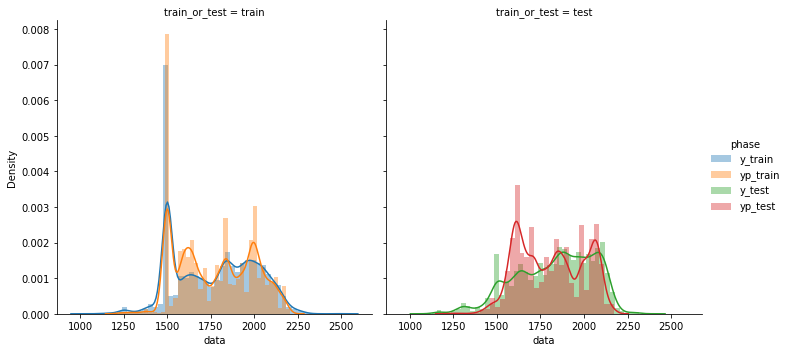

In [64]:
data = np.concatenate([y_train, yp_train, y_test, yp_test])
phase = ["y_train"]*len(y_train) + ["yp_train"]*len(yp_train) + ["y_test"]*len(y_test) + ["yp_test"]*len(yp_test)
train_or_test = ["train"]*(len(y_train)+len(yp_train)) + ["test"]*(len(y_test)+len(yp_test))
a = pd.DataFrame({"data":data, "phase":phase, "train_or_test":train_or_test})
graph = sns.FacetGrid(a, hue="phase", col="train_or_test",  size=5)
graph.map(sns.distplot, "data")
graph.add_legend()

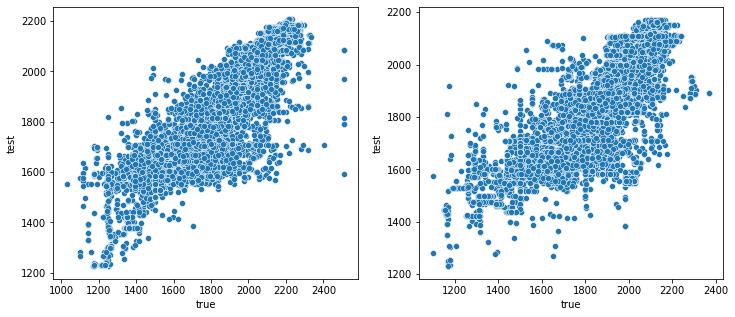

In [74]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121)
ax.set_xlabel("true")
ax.set_ylabel("test")
sns.scatterplot(y_train, yp_train, ax=ax)
ax = fig.add_subplot(122)
ax.set_xlabel("true")
ax.set_ylabel("test")
sns.scatterplot(y_test, yp_test, ax=ax)
plt.show()

In [75]:
print(yp_test.min(), yp_test.max())

1229.0 2173.0


In [77]:
# submit用のモデル作る
model = RandomForest_rint(**best_params)
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(mean_squared_error(y_train, y_pred, squared=False))

y_sub = model.predict(X_sub)

df_sub = pd.DataFrame({"game_id":df_sub["game_id"], "rating":y_sub})
df_sub.head()

75.11716325334585


,game_id,rating
0,2,1999.0
1,7,1843.0
2,11,1812.0
3,14,1843.0
4,27,2024.0


1268.0 2176.0


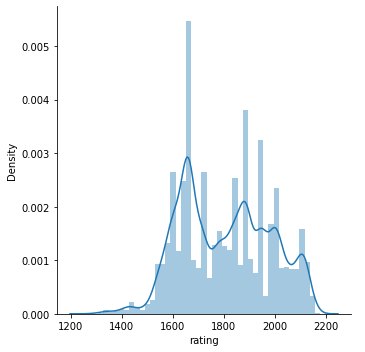

In [83]:
print(y_sub.min(), y_sub.max())
graph = sns.FacetGrid(df_sub, size=5)
graph.map(sns.distplot, "rating")
graph.add_legend()

In [80]:
now = datetime.now()
now = now.astimezone(timezone('Asia/Tokyo'))
df_sub.to_csv(f"submission/{now}-RandomForest_rint.csv", index=None)